In [1]:
# Import NumPy for numerical computations
import numpy as np

# Import TensorFlow, a popular machine learning framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import TensorFlow Addons, which provides additional functionality for TensorFlow
import tensorflow_addons as tfa

# Import Matplotlib for data visualization
import matplotlib.pyplot as plt

# Import NumPy again (Note: Importing libraries twice is not necessary)
import numpy as np

# Import OpenCV for computer vision tasks
import cv2

# Import the os module for interacting with the operating system
import os

# Import SciPy's .mat file reader for handling MATLAB data files
import scipy.io

# Import shutil for file operations (e.g., copying, moving, deleting files)
import shutil

# Import NumPy for numerical computations
import numpy as np

# Import TensorFlow, a popular machine learning framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import TensorFlow Addons, which provides additional functionality for TensorFlow
import tensorflow_addons as tfa

# Import Matplotlib for data visualization
import matplotlib.pyplot as plt

# Import NumPy again (Note: Importing libraries twice is not necessary)
import numpy as np

# Import OpenCV for computer vision tasks
import cv2

# Import the os module for interacting with the operating system
import os

# Import SciPy's .mat file reader for handling MATLAB data files
import scipy.io

# Import shutil for file operations (e.g., copying, moving, deleting files)
import shutil
import pandas as pd

c:\Users\Asus\Desktop\TCT_data\huenv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [73]:
import os
import pandas as pd
import numpy as np
from PIL import Image

# Path to your annotation CSV
csv_path = "../csvfiles/fold1/train.csv"  # <- update as needed
df = pd.read_csv(csv_path)

# Extract image paths and verify they exist
image_paths = df['image_path'].tolist()
image_paths = [p for p in image_paths if os.path.exists(p)]

# Extract annotation strings
annot_strings = df['annotation'].tolist()
annot_strings = [a if isinstance(a, str) else "" for a in annot_strings]

image_size = 224  # Resize all images

images, targets = [], []

for i in range(len(image_paths)):
    image = Image.open(image_paths[i]).convert('RGB')
    original_size_x = image.size[0]
    original_size_y = image.size[1]
    x_scale = ( 224 / original_size_x)
    y_scale = ( 224 / original_size_y)

    
    # ✅ Resize ALL images
    image = image.resize((image_size, image_size))

    images.append(np.array(image))

    # Parse annotation
    annots = annot_strings[i].split(";")
    boxes = []
    for ann in annots:
        if len(ann.strip()) == 0:
            continue
        coords = ann[2:].strip().split()
        coords = list(map(float, coords))
        x_coords = coords[::2]
        y_coords = coords[1::2]
        xmin, xmax = min(x_coords), max(x_coords)
        ymin, ymax = min(y_coords), max(y_coords)

        boxes.append((
            xmin * x_scale,
            ymin * y_scale,
            xmax * x_scale,
            ymax * y_scale
        ))

    targets.append(boxes[0] if boxes else (0, 0, 0, 0))

# Convert to NumPy arrays
x_all = np.asarray(images)
y_all = np.asarray(targets)

# Split into train/test
split_idx = int(len(x_all) * 0.8)
x_train, y_train = x_all[:split_idx], y_all[:split_idx]
x_test, y_test = x_all[split_idx:], y_all[split_idx:]

In [74]:
def mlp(x, hidden_units, dropout_rate):
    # Iterate through the list of hidden units
    for units in hidden_units:
        # Apply a Dense layer with the GELU activation function
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        
        # Apply a Dropout layer with a specified dropout rate
        x = layers.Dropout(dropout_rate)(x)
    
    # Return the final output after processing through the MLP
    return x

In [75]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
    # Override the 'get_config' function to ensure model saving compatibility
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "patch_size": patch_size,
            }
        )
        return config
    def call(self, images):
        # Get the batch size of the input images
        batch_size = tf.shape(images)[0]
        # Extract image patches using TensorFlow's 'extract_patches' function
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        # Reshape the patches to have the shape [batch_size, num_patches, patch_size * patch_size * channels]
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


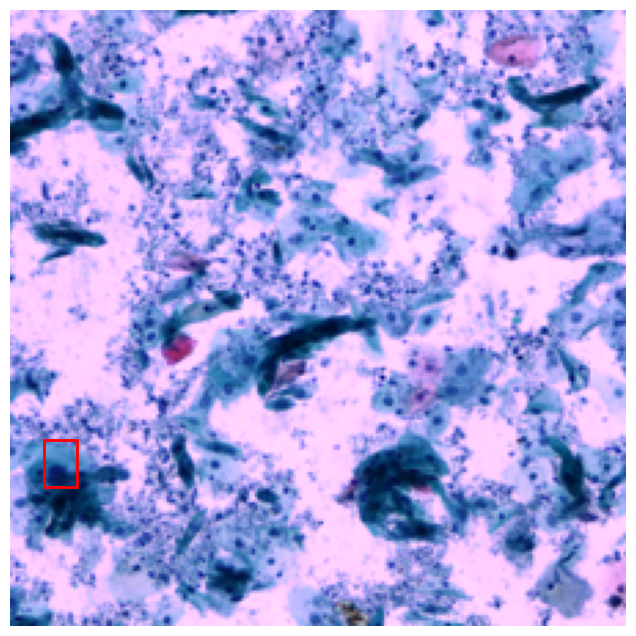

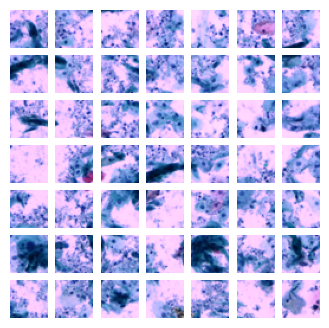

In [76]:
# Define the size of the patches to be extracted from the input images
patch_size = 32

# Display the original image
plt.figure(figsize=(8, 8))
plt.imshow(x_train[0].astype("uint8"))  # Display the first training image
bbox = y_train[0]
xmin = int(bbox[0])
ymin = int(bbox[1])
xmax = int(bbox[2])
ymax = int(bbox[3])

# Draw the box
rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                     edgecolor='red', facecolor='none', linewidth=2)
plt.gca().add_patch(rect)

plt.axis("off")  # Turn off axis labels and ticks

# Extract patches from the image using the 'Patches' layer
patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))

# Print information about the image and patch sizes
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

# Calculate the number of patches to be displayed in each row and column
n = int(np.sqrt(patches.shape[1]))

# Create a new figure for displaying the extracted patches
plt.figure(figsize=(4, 4))

# Iterate through and display each patch
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)  # Create a subplot
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))  
    # Reshape the patch to image dimensions
    plt.imshow(patch_img.numpy().astype("uint8"))  # Display the patch as an image
    plt.axis("off")  # Turn off axis labels and ticks for the patch

In [77]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches

        # Initialize a Dense layer for projection
        self.projection = layers.Dense(units=projection_dim)

        # Initialize an Embedding layer for position embeddings
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override the 'get_config' function to ensure model saving compatibility
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "num_patches": num_patches,
                "projection_dim": projection_dim,
            }
        )
        return config

    def call(self, patch):
        # Create positions for the patches
        positions = tf.range(start=0, limit=self.num_patches, delta=1)

        # Perform projection and add position embeddings to the patches
        encoded = self.projection(patch) + self.position_embedding(positions)

        # Return the encoded patches
        return encoded

In [78]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    # Define the input layer for the model
    inputs = layers.Input(shape=input_shape)
    
    # Create patches from input images
    patches = Patches(patch_size)(inputs)
    
    # Encode the patches using the PatchEncoder layer
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Apply multi-head self-attention to the patches
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # Apply an MLP to the output
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    
    # Add an additional MLP for feature extraction
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    # Output layer with 4 neurons representing bounding box coordinates
    bounding_box = layers.Dense(4)(features)

    # Return the Keras model
    return keras.Model(inputs=inputs, outputs=bounding_box)

In [79]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):
    # Define the optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile the model using Mean Squared Error as the loss
    model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

    # Set up a ModelCheckpoint to save the best model weights
    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    # Train the model
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history

# Define input image shape and training hyperparameters
input_shape = (image_size, image_size, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100

# Calculate the number of patches
num_patches = (image_size // patch_size) ** 2

# Define the dimensions and layers for the Vision Transformer (ViT) model
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]

# Initialize a list to store training history
history = []

# Create a ViT-based object detection model
vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train the model and store the training history
history = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/100
126/126 [==============================] - 39s 266ms/step - loss: 6608.7793 - val_loss: 3649.1423
Epoch 2/100
126/126 [==============================] - 33s 263ms/step - loss: 5436.4194 - val_loss: 3609.1030
Epoch 3/100
126/126 [==============================] - 33s 265ms/step - loss: 5276.6396 - val_loss: 3872.0974
Epoch 4/100
126/126 [==============================] - 33s 264ms/step - loss: 5235.9009 - val_loss: 3934.6768
Epoch 5/100
126/126 [==============================] - 33s 264ms/step - loss: 4962.6519 - val_loss: 3625.4707
Epoch 6/100
126/126 [==============================] - 34s 267ms/step - loss: 5088.9565 - val_loss: 4217.4106
Epoch 7/100
126/126 [==============================] - 33s 263ms/step - loss: 5015.2705 - val_loss: 3787.2622
Epoch 8/100
126/126 [==============================] - 33s 265ms/step - loss: 5011.5127 - val_loss: 3590.7351
Epoch 9/100
126/126 [==============================] - 33s 265ms/step - loss: 4932.5576 - val_loss: 3716.0247
Epoch 10/1

In [80]:
import matplotlib.patches as patches

# Save the ViT-based object detection model in the current path
vit_object_detector.save("vit_object_detector.h5", save_format="h5")

# Define a function to calculate Intersection over Union (IoU) for two bounding boxes
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # Get the (x, y) coordinates of the intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # Calculate the area of the intersection bounding box
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # Calculate the area of the prediction bounding box and ground-truth bounding box
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # Calculate Intersection over Union by taking the intersection area
    # and dividing it by the sum of predicted bounding box and ground truth
    # bounding box areas, subtracted by the intersection area

    # Return IoU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )

c:\Users\Asus\Desktop\TCT_data\huenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 26ms/step
mean_iou: 0.0


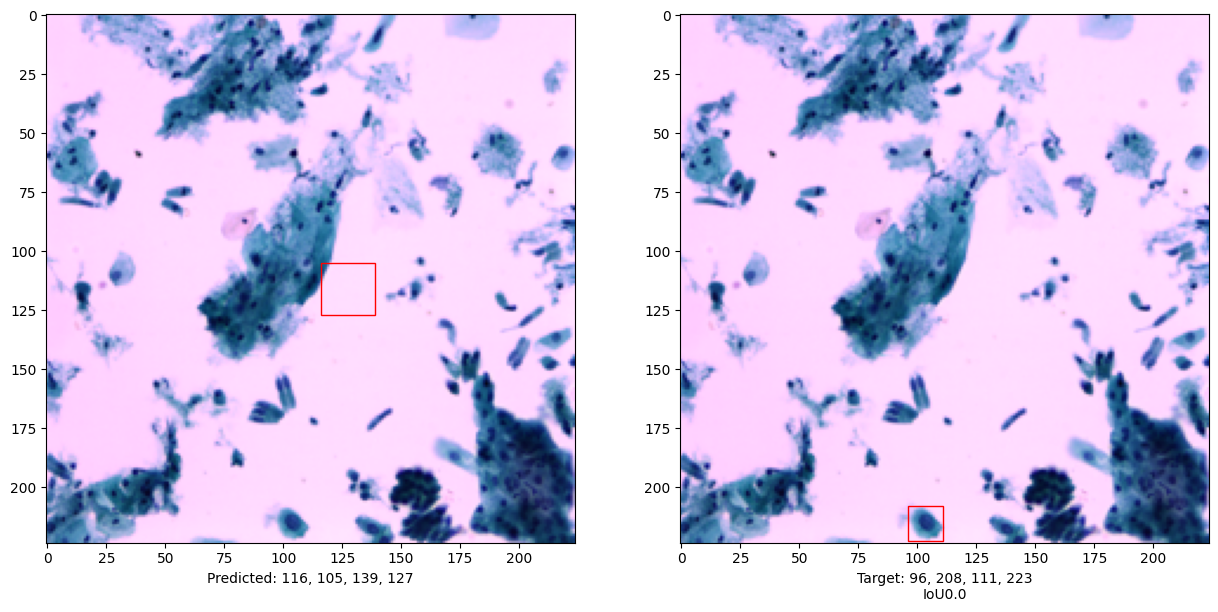

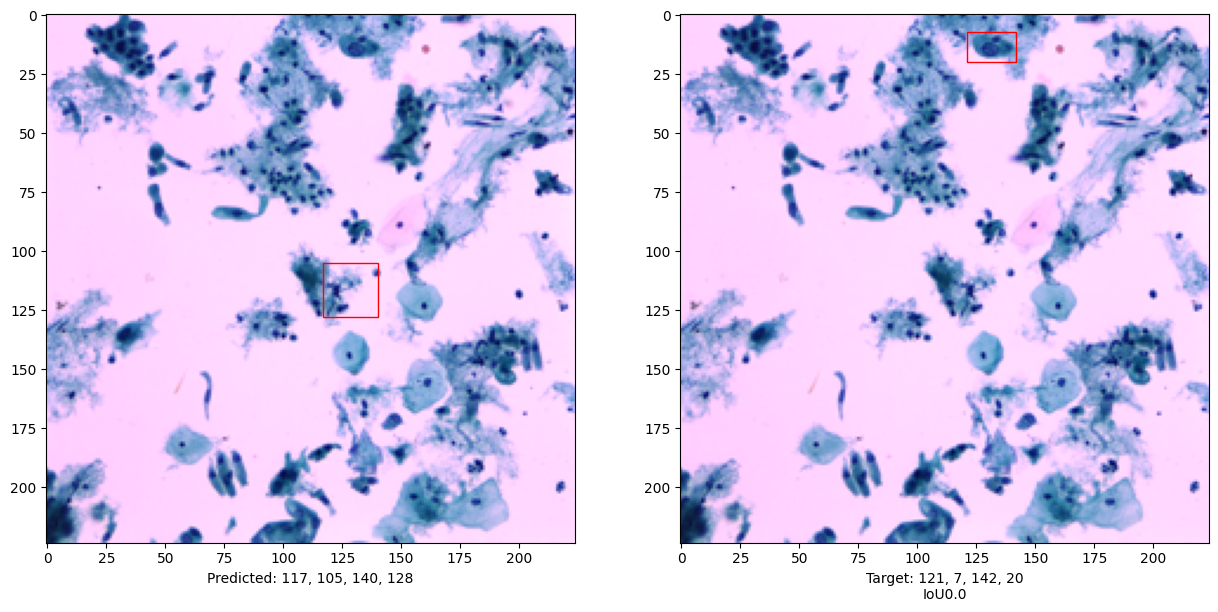

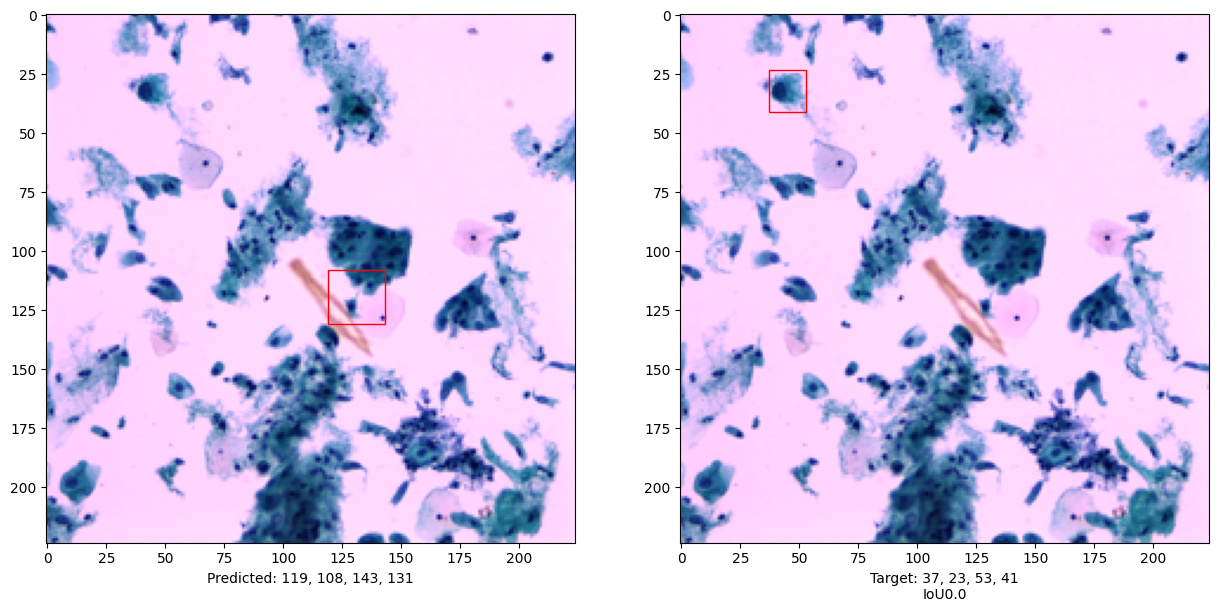

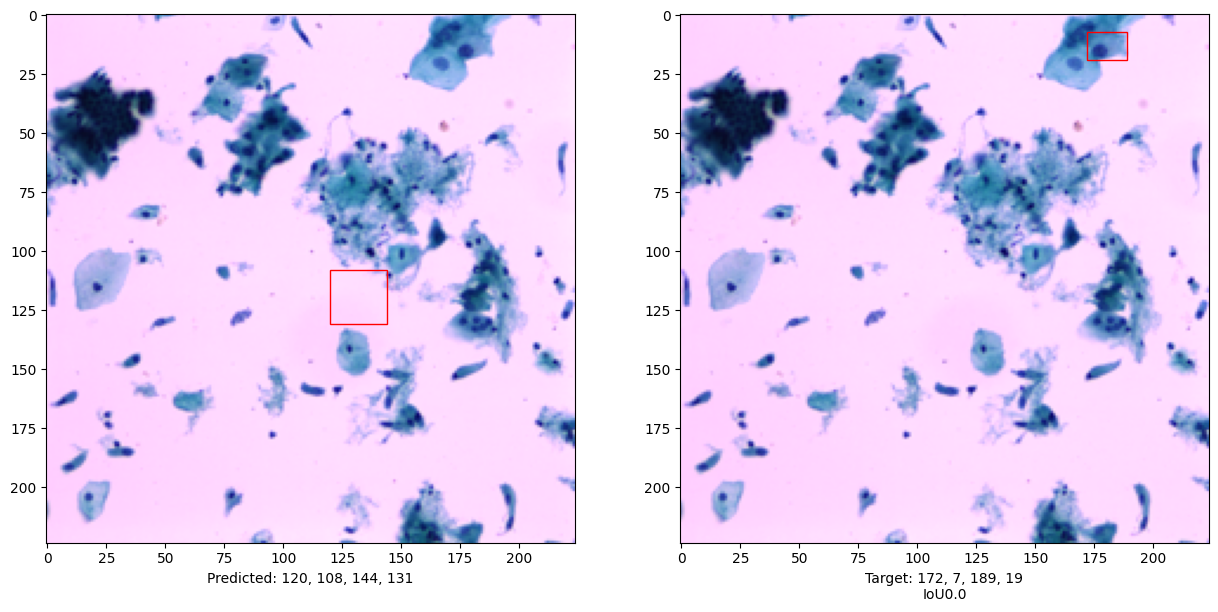

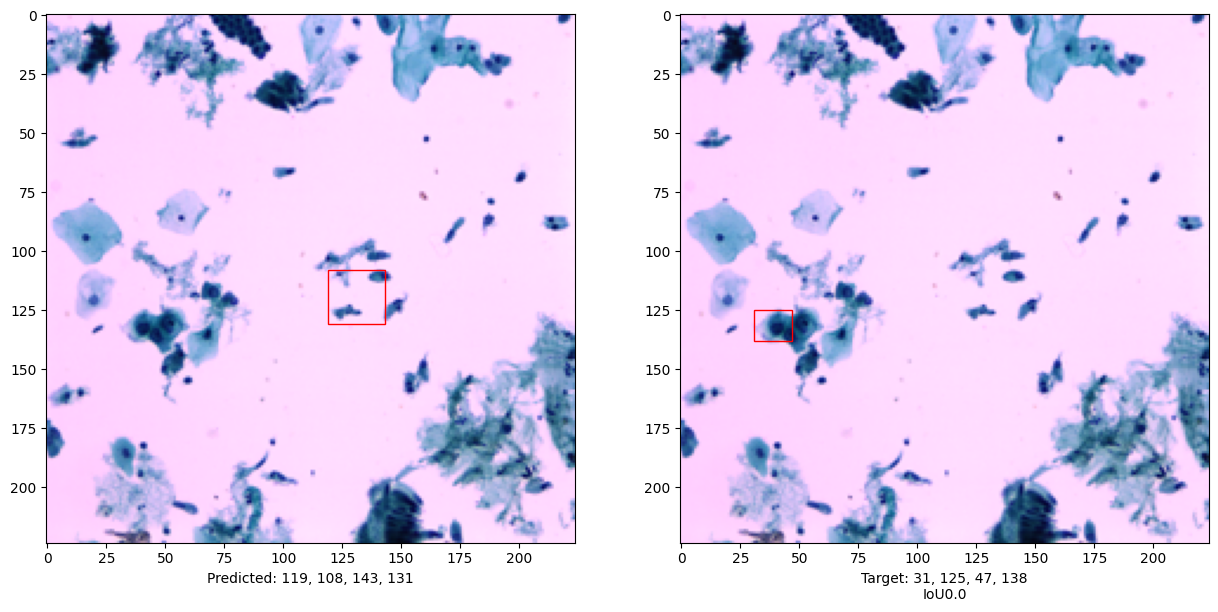

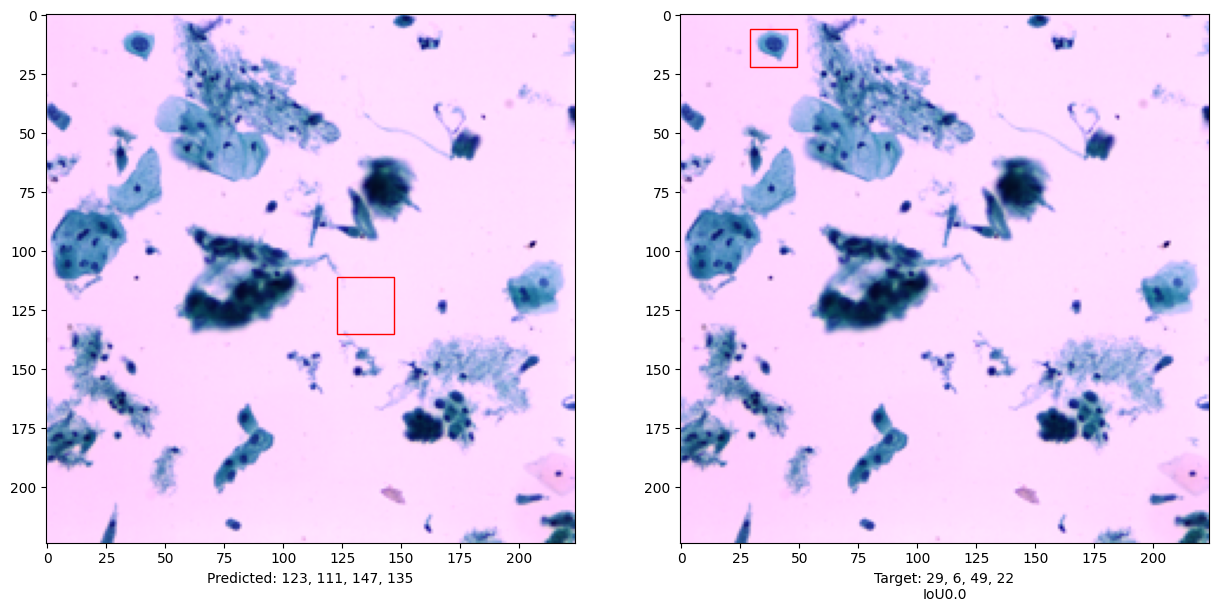

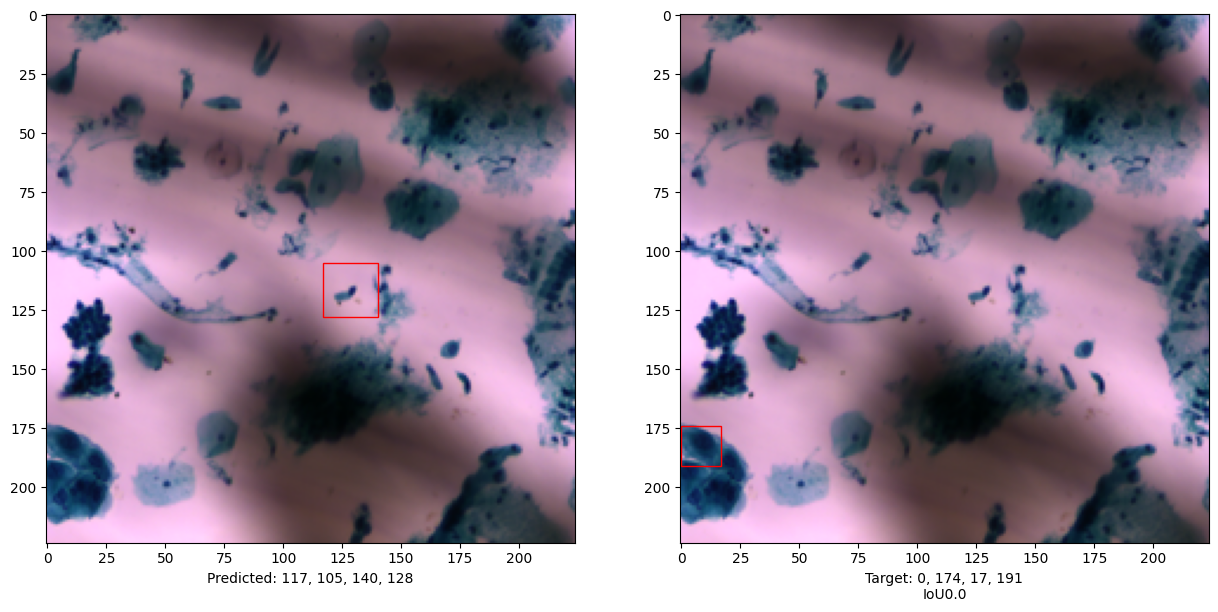

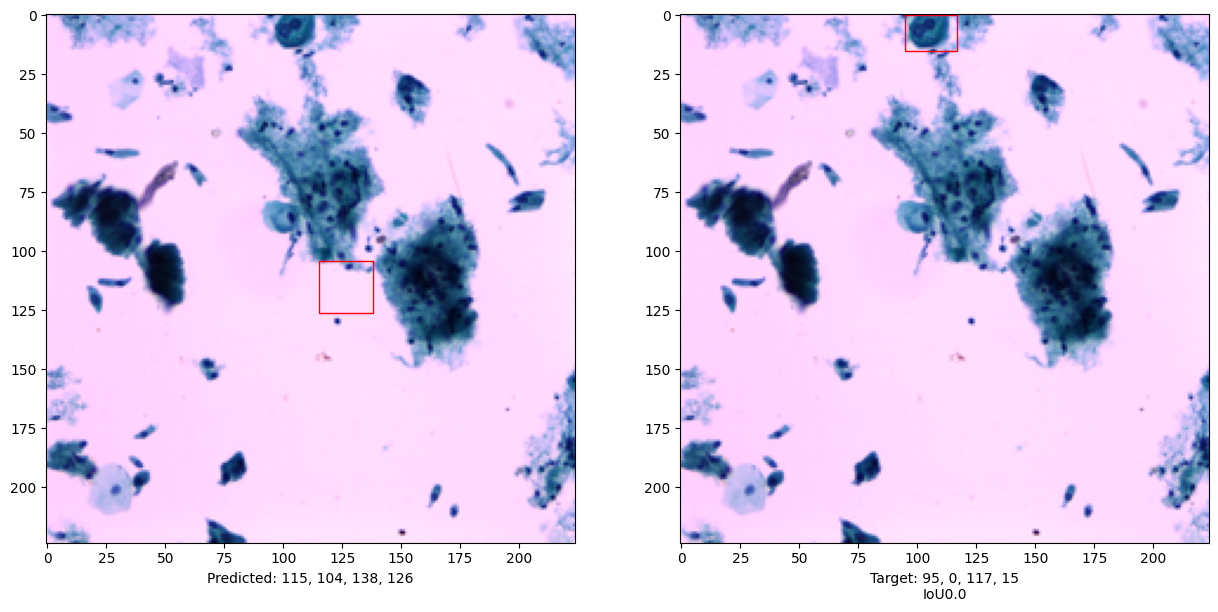

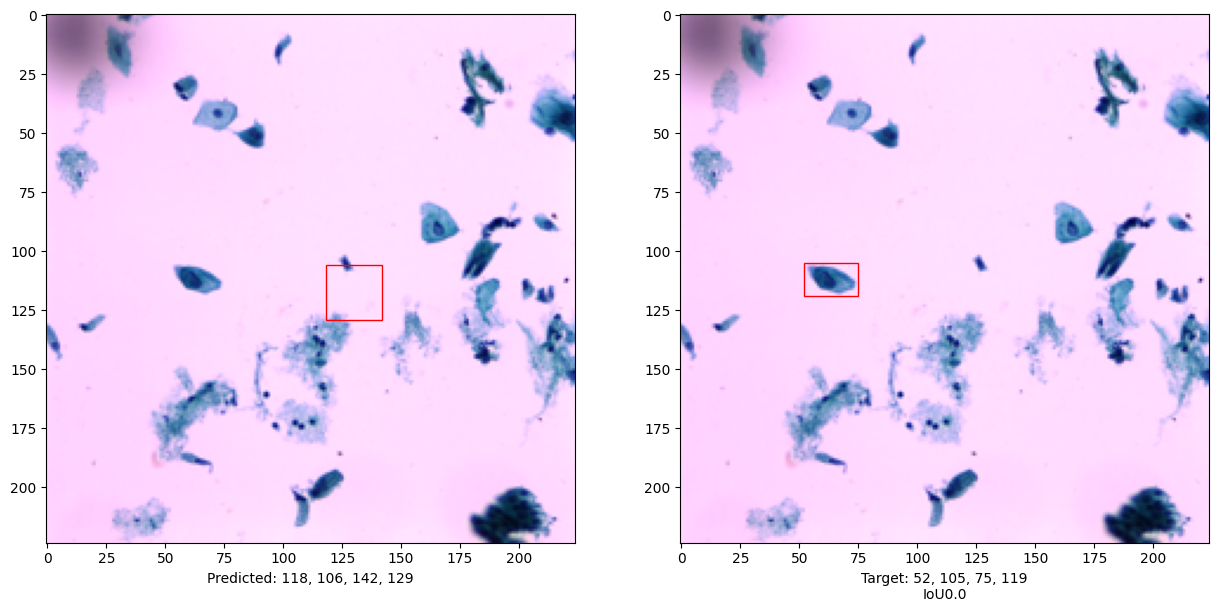

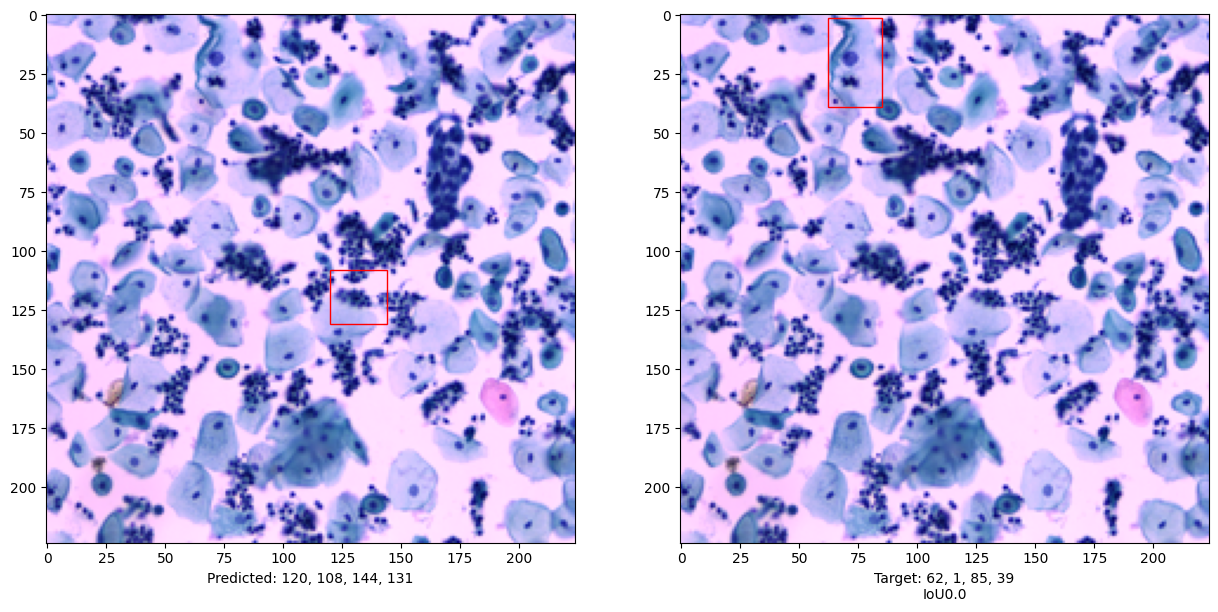

In [81]:
i, mean_iou = 0, 0  # Initialize variables to keep track of the index and mean IoU

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the original image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    # Resize the input image to the specified image size
    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    
    # Make predictions using the ViT object detector
    preds = vit_object_detector.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    # Extract bounding box coordinates from predictions
    top_left_x, top_left_y = int(preds[0]), int(preds[1])
    bottom_right_x, bottom_right_y = int(preds[2]), int(preds[3])

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    
    # Create a bounding box visualization
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    # Extract ground truth bounding box coordinates
    top_left_x, top_left_y = int(y_test[i][0]), int(y_test[i][1])
    bottom_right_x, bottom_right_y = int(y_test[i][2]), int(y_test[i][3])

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    # Calculate Intersection over Union (IoU) and update the mean IoU
    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    
    # Create a bounding box visualization for ground truth
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1  # Increment the index

# Calculate and print the mean IoU for the 10 images
print("mean_iou: " + str(mean_iou / len(x_test[:10])))

# Show the images with bounding box visualizations
plt.show()

In [ ]:
# python lazyconfig_train_net.py \
#   --config-file mask_rcnn_vitdet_b_100ep.py \
#   train.output_dir=./output/vitdet_b \
#   dataloader.train.dataset.names='("tct_train",)' \
#   dataloader.test.dataset.names='("tct_val",)' \
#   model.roi_heads.num_classes=1 \
#   model.mask_on=False

python lazyconfig_train_net.py   --config-file mask_rcnn_vitdet_b_100ep.py   train.output_dir=./output/vitdet_b   model.roi_heads.num_classes=1